This script makes parse_XML_with_minidom_ML more modular

Also add url, page_type of articles

Compare different models: LSI, RP, LDA, HDP

In [1]:
import sys, os
from xml.dom import minidom
import nltk
import pandas as pd

from collections import defaultdict
from gensim import corpora, models, similarities

%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

C:\Users\melanie\Anaconda3\envs\cdips2017\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir('data')
xmlfile = 'Wikipedia-20170717213140.xml'

In [3]:
def get_page_type(title):
    """
    from WikiPage.py: extract page type from article title
    """
    if 'Category:' in title:
        return 'category'
    elif 'Portal:' in title:
        return 'portal'
    elif 'List of' in title:
        return 'list'
    elif 'File:' in title:
        return 'file'
    else:
        return 'article'

def xml_to_df(xmlfile):
    """
    input: xml filename
    output: data frame with columns: article id, title, url, page_type, tokenized text
    
    filter out pages that are not articles
    """
    xmldoc = minidom.parse(xmlfile)
    idlist = xmldoc.getElementsByTagName('id')
    titlelist = xmldoc.getElementsByTagName('title')
    textlist = xmldoc.getElementsByTagName('text')
    
    titles = [title.childNodes[0].data for title in titlelist]
    urllist = ['https://en.wikipedia.org/wiki/%s' % (title.replace(' ', '_'))
              for title in titles]
    typelist = [get_page_type(title) for title in titles]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    
    word_data = [(id.childNodes[0].data, title, url, page_type,
                  tokenizer.tokenize(text.childNodes[0].data.lower()))
                for id, title, url, page_type, text in zip(idlist, titles, urllist, typelist, textlist)
                if page_type == 'article']
    word_data_df = pd.DataFrame(word_data, columns=['id', 'title', 'url', 'type', 'words'])
    #word_data_df.to_csv('word_data_df.csv')
    return(word_data_df)

In [4]:
word_data_df = xml_to_df(xmlfile)
word_data_df.head()

,id,title,url,type,words
0,5957048,Kennel,https://en.wikipedia.org/wiki/Kennel,article,"[about, shelter, for, dogs, and, cats, for, th..."
1,729436,Cynology,https://en.wikipedia.org/wiki/Cynology,article,"[cynology, ipac, en, s, ᵻ, ˈ, n, ɒ, l, ə, dʒ, ..."
2,1764821,Pack (canine),https://en.wikipedia.org/wiki/Pack_(canine),article,"[other, uses, wolfpack, disambiguation, image,..."
3,547372987,Rare breed (dog),https://en.wikipedia.org/wiki/Rare_breed_(dog),article,"[for, a, list, of, rare, dog, breeds, category..."
4,547375119,Dogs in ancient China,https://en.wikipedia.org/wiki/Dogs_in_ancient_...,article,"[refimprove, date, december, 2008, originalres..."


In [5]:
word_data_df.tail()

,id,title,url,type,words
89,787653468,Cat,https://en.wikipedia.org/wiki/Cat,article,"[about, the, cat, species, that, is, commonly,..."
90,41493138,Cat bite,https://en.wikipedia.org/wiki/Cat_bite,article,"[infobox, disease, name, cat, bite, image, cat..."
91,701109732,Ancylostoma tubaeforme,https://en.wikipedia.org/wiki/Ancylostoma_tuba...,article,"[italic, title, taxobox, image, name, ancylost..."
92,754619,Feline diseases,https://en.wikipedia.org/wiki/Feline_diseases,article,"[further, feline, zoonosis, see, cat, health, ..."
93,849619,International Cat Day,https://en.wikipedia.org/wiki/International_Ca...,article,"[infobox, holiday, holiday_name, international..."


In [6]:
def make_dictionary(documents):
    """
    construct a dictionary, i.e. mapping btwn word ids and their freq of occurence in the whole corpus
    filter dictionary to remove stopwords and words occuring < min_count times
    
    input: documents is an iterable consisting of all the words in the corpus 
    output: filtered dictionary
    """
    dictionary = corpora.Dictionary(documents)

    stop_words = nltk.corpus.stopwords.words('english') 
    min_count = 2
    stop_ids = [dictionary.token2id[word] for word in stop_words
               if word in dictionary.token2id]
    rare_ids = [id for id, freq in dictionary.dfs.items()
                if freq < min_count]
    dictionary.filter_tokens(stop_ids + rare_ids)
    dictionary.compactify()
    return(dictionary)

def make_corpus(word_data_df):
    """
    """
    documents = word_data_df['words'].values
    dictionary = make_dictionary(documents)
    # convert corpus to vectors using bag-of-words representation, i.e. tuples of word indices and word counts
    corpus = [dictionary.doc2bow(words) for words in documents]
    return(corpus, dictionary)

def make_lsi_similarity_matrix(tfidf_corpus, dictionary):
    """
    construct LSI (latent semantic indexing) model on Tfidf-transformed corpus, print model topics, 
    return similarity matrix.
    """
    # construct model
    lsi = models.lsimodel.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=50) 
    lsi.save('wiki.lsi')
    for i, topic in enumerate(lsi.print_topics(5)[:3]):
        print('Topic: ', format(i))
        print(str(topic).replace(' + ', '\n')) 
        print('') 
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(lsi[tfidf_corpus], num_best=6)
    return(matsim)

def print_similar_articles(word_data_df, matsim, num_print):
    """
    print titles of first num_print articles and their most similar articles and similarity scores.
    this is independent of model used.
    """
    titles = word_data_df['title']
    # for the first num_print articles, print most similar articles and their similarity scores
    for sims in list(matsim)[:num_print]:
        title_index = sims[0][0]
        print(titles[title_index]) 
        for other_title_index, score in sims[1:]:
            print('\t', titles[other_title_index], ' ', score) 

In [7]:
corpus, dictionary = make_corpus(word_data_df)
tfidf = models.TfidfModel(corpus)
lsi_matsim = make_lsi_similarity_matrix(tfidf[corpus], dictionary)

Topic:  0
(0, '0.301*"cat"
0.219*"cats"
0.192*"dog"
0.155*"journal"
0.115*"meat"
0.094*"name"
0.091*"dogs"
0.090*"feral"
0.090*"doi"
0.089*"volume"')

Topic:  1
(1, '-0.415*"cat"
-0.345*"cafe"
0.316*"dog"
-0.250*"cats"
-0.138*"café"
0.132*"dogs"
0.130*"breed"
0.111*"wagging"
0.111*"kennel"
0.104*"breeds"')

Topic:  2
(2, '-0.273*"meat"
0.253*"bites"
-0.224*"cafe"
0.222*"bite"
0.173*"rabies"
0.161*"cdc"
-0.144*"festival"
-0.135*"china"
0.127*"infection"
0.114*"wagging"')



In [8]:
print_similar_articles(word_data_df, lsi_matsim, 10)

Kennel
	 Cattery   0.814780771732
	 Indian National Kennel Club   0.573465406895
	 Dog World (newspaper)   0.334808826447
	 Breed type (dog)   0.3020645082
	 Lists of dogs   0.271350085735
Cynology
	 Felinology   0.48828369379
	 Cat training   0.420496493578
	 Pussy   0.377251684666
	 Breed type (dog)   0.296519637108
	 Pack (canine)   0.261724859476
Pack (canine)
	 Canid hybrid   0.631985366344
	 Origin of the domestic dog   0.611404001713
	 Dog   0.514093697071
	 Canine reproduction   0.488296687603
	 Cat training   0.443291783333
Rare breed (dog)
	 Breed type (dog)   0.882066190243
	 Lists of dogs   0.285880744457
	 Dog   0.284888446331
	 Dog bite   0.282038062811
	 Cynology   0.226576387882
Dogs in ancient China
	 Dogs in Mesoamerica   0.659915149212
	 Dogs in religion   0.606493592262
	 Panhu   0.505573272705
	 Origin of the domestic dog   0.472601473331
	 Dog   0.389480471611
Dog biscuit
	 Dog food   0.84871327877
	 Dog daycare   0.35606315732
	 Cat meat   0.250419855118
	 Dog me

In [9]:
def make_rp_similarity_matrix(tfidf_corpus, dictionary):
    """
    construct RP (random projections) model on Tfidf-transformed corpus, print model topics, 
    return similarity matrix.
    """
    # construct model
    rp = models.RpModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=50)
    rp.save('wiki.rp_model')
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(rp[tfidf_corpus], num_best=6)
    return(matsim)

In [10]:
rp_matsim = make_rp_similarity_matrix(tfidf[corpus], dictionary)
print_similar_articles(word_data_df, rp_matsim, 10)

Kennel
	 Lists of dogs   0.436798989773
	 Queen Elizabeth's corgis   -0.284243643284
	 Panhu   -0.273537844419
	 Point coloration   -0.269412070513
	 Indian National Kennel Club   0.266682177782
Cynology
	 Dog bite prevention   0.356828838587
	 Cat training   0.355660587549
	 Rabies in Haiti   0.322659730911
	 Cattery   -0.304761022329
	 Human–canine bond   0.301070332527
Pack (canine)
	 Cats in ancient Egypt   0.50925463438
	 Cattery   0.342242389917
	 Chiengora   0.265731751919
	 Cynophobia   -0.265317171812
	 Canid hybrid   0.261208415031
Rare breed (dog)
	 Becerrillo   0.371126830578
	 Cat senses   0.359707027674
	 Toe tuft   0.352812469006
	 The Ten Commandments of Dog Ownership   0.340020090342
	 Operation Cat Drop   0.337324947119
Dogs in ancient China
	 Becerrillo   0.300692617893
	 The Ten Commandments of Dog Ownership   0.297840863466
	 The Dog Pillow   0.290950924158
	 Dogs in Mesoamerica   0.288932651281
	 Bog Dog   -0.253949701786
Dog biscuit
	 Cat gap   0.48980897665
	 Ro

In [11]:
def make_lda_similarity_matrix(corpus, dictionary):
    """
    Latent Dirichlet Allocation (LDA) model
    """
    # construct model
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=50)
    lda.save('wiki.lda')
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(lda[corpus], num_best=6)
    return(matsim)

In [12]:
lda_matsim = make_lda_similarity_matrix(corpus, dictionary)
print_similar_articles(word_data_df, lda_matsim, 10)

Kennel
	 Ailurophobia   0.902773618698
	 Dogs in religion   0.877971827984
	 Cabbit   0.877971827984
	 Dog daycare   0.877971827984
	 The Ten Commandments of Dog Ownership   0.877971827984
Cabbit
	 Dog World (newspaper)   1.0
	 The Ten Commandments of Dog Ownership   1.0
	 Pet Check Technology   1.0
	 Chiengora   1.0
	 Dog daycare   1.0
Pack (canine)
	 Cat bite   0.632908463478
	 Toe tuft   0.632908463478
	 Hermitage cats   0.632908463478
	 Feline zoonosis   0.630945026875
	 Cat training   0.621360957623
Rare breed (dog)
	 Dog meat   0.712741315365
	 Becerrillo   0.711976051331
	 Walter the Farting Dog   0.70429199934
	 Kitten   0.628097951412
	 Puppy   0.622540891171
Dogs in ancient China
	 Cynophobia   0.995763003826
	 Dogs in Mesoamerica   0.995763003826
	 Bog Dog   0.995763003826
	 My Life in Dog Years   0.951556324959
	 Service dog   0.892857372761
Dog biscuit
	 Felinology   0.86493909359
	 Dogs in religion   0.501876890659
	 Dog daycare   0.501876890659
	 Dog World (newspaper)   

In [13]:
def make_hdp_similarity_matrix(corpus, dictionary):
    """
    Hierachical Dirichlet Process (HDP) model
    """
    # construct model
    hdp = models.HdpModel(corpus, id2word=dictionary)
    hdp.save('wiki.hdp')
    # create similarity matrix
    matsim = similarities.MatrixSimilarity(hdp[corpus], num_best=6)
    return(matsim)

In [14]:
hdp_matsim = make_hdp_similarity_matrix(corpus, dictionary)
print_similar_articles(word_data_df, hdp_matsim, 10)

Kennel
	 Dog meat   0.272486180067
	 Cat café   0.272486180067
	 Cat meat   0.272486180067
	 Dog Parker   0.272486180067
	 Cats in ancient Egypt   0.272486180067
Cynology
	 Dogs in religion   0.993338823318
	 Panhu   0.103145524859
Pack (canine)
	 The Ten Commandments of Dog Ownership   0.812229812145
	 Dog   0.0966325029731
	 Interbreeding of dingoes with other domestic dogs   0.0966325029731
	 Human interaction with cats   0.0942210331559
	 Cat bite   0.0884289741516
Rare breed (dog)
	 Cat café   0.151977986097
	 Dog meat   0.151977986097
	 Cropping (animal)   0.151977986097
	 Cats in ancient Egypt   0.151977986097
	 Dog Parker   0.151977986097
Dogs in ancient China
	 Origin of the domestic dog   0.098118647933
	 Canid hybrid   0.0980323925614
	 Dog bite   0.0974372923374
	 The Dog Pillow   0.0215223096311
	 Rolfi   0.00197387207299
Dog biscuit
	 Cats in ancient Egypt   0.0198615882546
	 Dog meat   0.0198615882546
	 Cat café   0.0198615882546
	 Cat meat   0.0198615882546
	 Dog Parker

In [15]:
# plot projection of articles onto 2 axes/topics defined by the model
def plot_axes(x, y, model, corpus, tfidf, titles):
    """Plot each article title according to the projection of its text 
    into the given x and y topic axes of model.
    
    :param x: the index of the x axis to plot
    :param y: the index of the y axis to plot
    :param model: the gensim model to project into
    :param corpus: the gensim corpus of documents
    :param tfidf: a tfidf model for converting documents into tfidf space
    :param titles: a list of article titles
    """
    x_data = defaultdict(list) 
    y_data = defaultdict(list) 
    arts = defaultdict(list)  
    for title, doc in zip(titles, corpus):
        x_data[0].append((model[tfidf[doc]][x][1]))
        y_data[0].append((model[tfidf[doc]][y][1]))
        arts[0].append(title)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plt.scatter(x_data[0], y_data[0], s=40)
    for art, x, y in zip(arts[0], x_data[0], y_data[0]):
        ax.annotate(str(art), xy=(x, y), xycoords='data', xytext=(1, 1), 
        textcoords='offset points', size=10)        

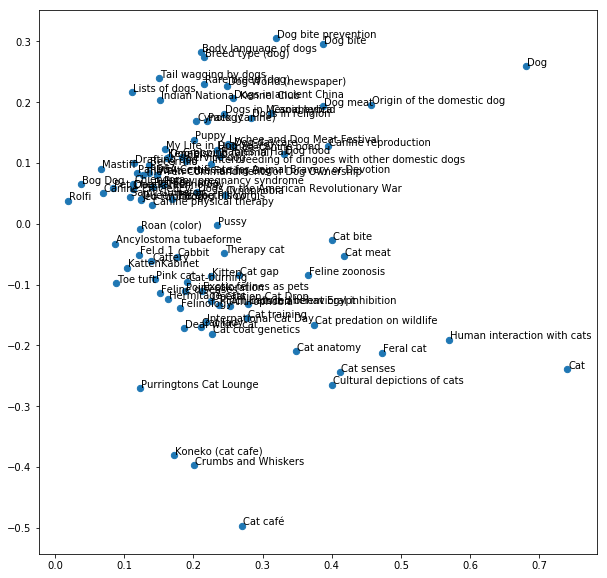

In [16]:
lsi = models.LsiModel.load('wiki.lsi')
titles = word_data_df['title']
plot_axes(x=0, y=1, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

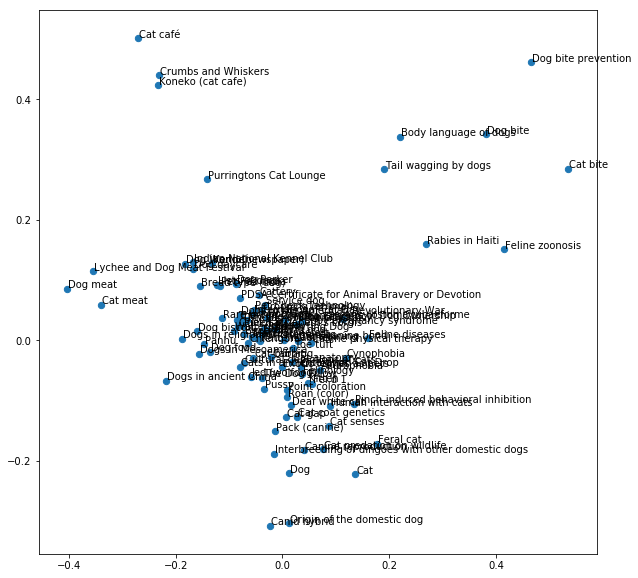

In [17]:
plot_axes(x=2, y=3, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

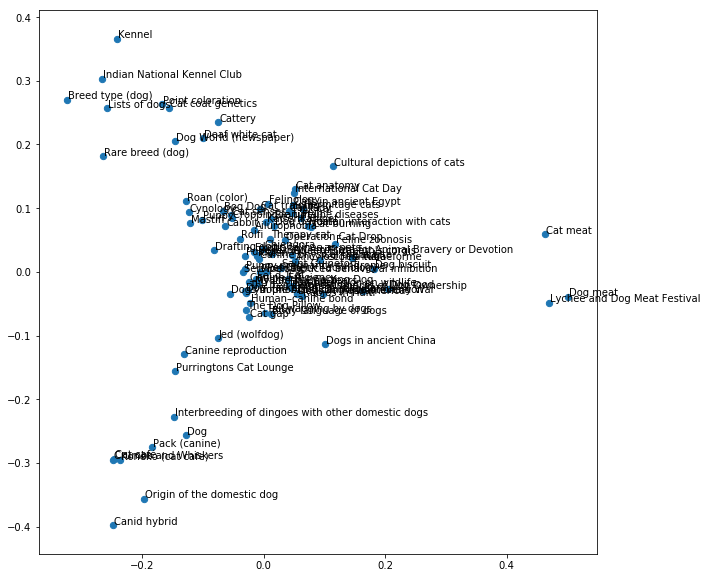

In [18]:
plot_axes(x=4, y=5, model=lsi, corpus=corpus, tfidf=tfidf, titles=titles)

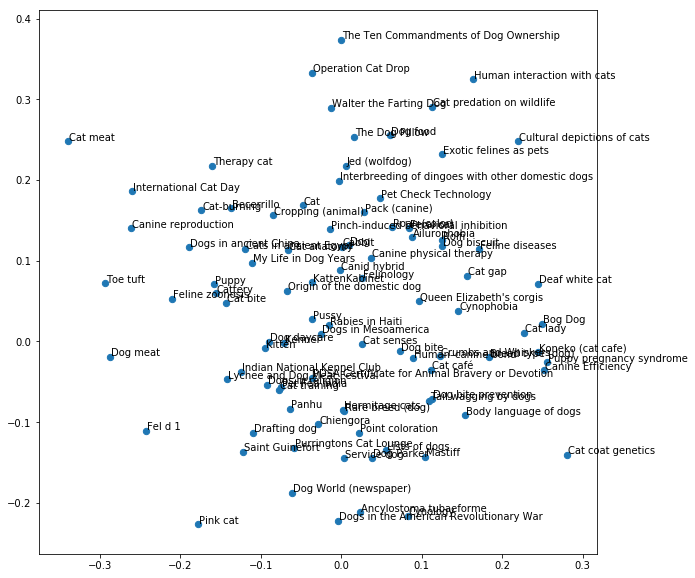

In [19]:
rp = models.RpModel.load('wiki.rp_model')
plot_axes(x=0, y=1, model=rp, corpus=corpus, tfidf=tfidf, titles=titles)